# Recommendations for E-Commerce Sales Consumers



Our project is to build and deploy a personalized recommendation engine according to purchase patters of consumers.

## Dataset

Dataset cource: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). 
It transactions occurring between 01/12/2010 and 09/12/2011 for an online retail store. 

Data columns:
+ InvoiceDate: Invoice Date and time. the day and time for each transaction
+ InvoiceNo: Invoice number, a 6-digit number assigned to each transaction. If code starts with 'c', it signifies a cancellation.
+ UnitPrice: Unit price. Product price per unit in sterling.
+ StockCode: Product code, a 5-digit number assigned to each distinct product.
+ Description: Product name
+ CustomerID: Customer number, a 5-digit number assigned to each customer.
+ Country: Country of residence for customer.
+ Quantity: The quantities of each product per transaction.



## Data Preprocessing


In [ ]:
!pip install sagemaker seaborn scipy scikit-learn

In [58]:
import sagemaker
import sagemaker.amazon.common as smac
import boto3

import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [88]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
print(f"using bucket{bucket} in region {region} \n")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
using bucketsagemaker-us-east-1-767397762857 in region us-east-1 



In [89]:
df = pd.read_csv("data/Online Retail.csv")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [90]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

delete rows with a missing CustomerID

In [91]:
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


/tmp/ipykernel_13490/1748766492.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["Quantity"], shade=True)  # shade=True shades the area under the curve


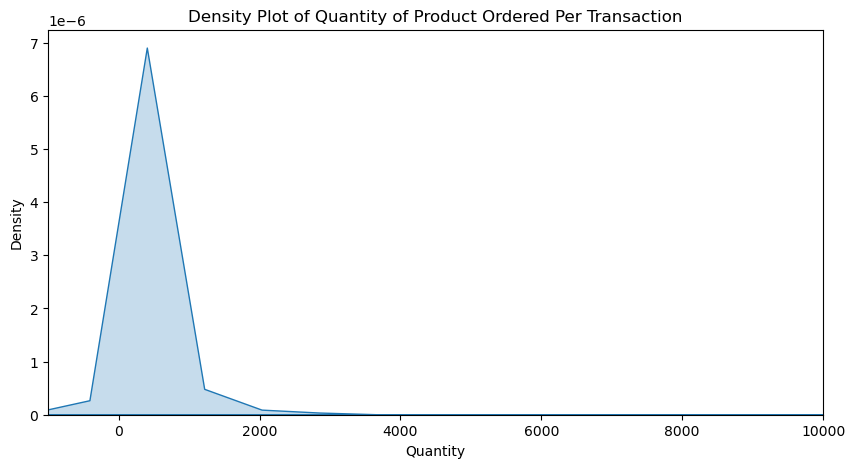

In [92]:
plt.figure(figsize=(10, 5))

# Create a density plot using seaborn
sns.kdeplot(df["Quantity"], shade=True)  # shade=True shades the area under the curve

plt.title("Density Plot of Quantity of Product Ordered Per Transaction")
plt.xlabel("Quantity")
plt.ylabel("Density")
plt.xlim(-1000, 10000)

plt.show()

Most of our quantities are realteively small (positive) numbers, but there are also some negative quantities as well as extreme outliers (both postiive and negative outliers). 

/tmp/ipykernel_13490/3949233968.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["UnitPrice"], shade=True)  # shade=True shades the area under the curve


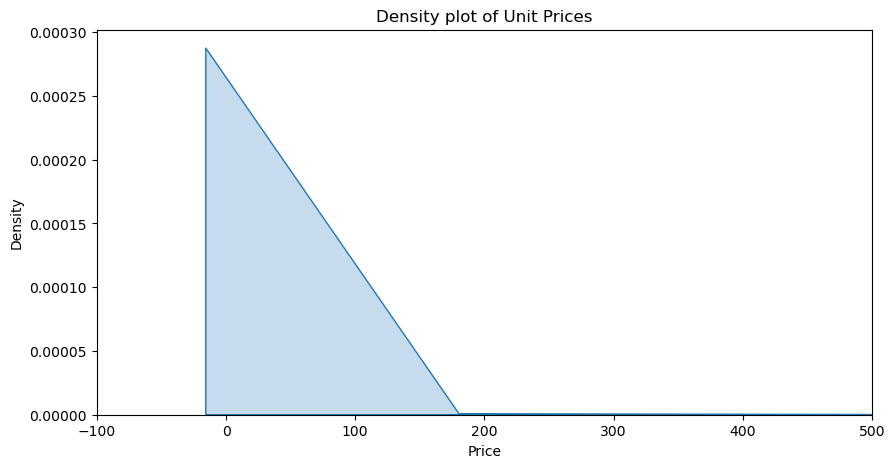

In [94]:
plt.figure(figsize=(10, 5))

# Create a density plot using seaborn
sns.kdeplot(df["UnitPrice"], shade=True)  # shade=True shades the area under the curve

plt.title("Density plot of Unit Prices")
plt.xlabel("Price")
plt.ylabel("Density")
plt.xlim(-100, 500)

plt.show()


There are no negative prices, which is good, but we can see some extreme outliers.

In [95]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [96]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])[
    "Quantity"
].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

In [97]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [98]:
X, y = loadDataset(df)

In [99]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

Our data is over 99.9% sparse. Because of this high sparsity, the sparse matrix data type allows us to represent our data using only a small fraction of the memory that a dense matrix would require.

### Prepare Data For Modeling

+ Split the data into training and testing sets
+ Write the data to protobuf recordIO format for Pipe mode. [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) about protobuf recordIO format.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

Save numpy arrays to local storage in /data folder


In [101]:
df.to_csv("data/online_retail_preprocessed.csv", index=False)
save_npz("data/X_train.npz", X_train)
save_npz("data/X_test.npz", X_test)
np.savez("data/y_train.npz", y_train)
np.savez("data/y_test.npz", y_test)

In [102]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [103]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

s3://sagemaker-us-east-1-767397762857/personalization/train/train.protobuf
s3://sagemaker-us-east-1-767397762857/personalization/test/test.protobuf
Output: s3://sagemaker-us-east-1-767397762857/personalization/output


## Part 2: Train, Tune, and Deploy Model
----
This second part will focus on training, tuning, and deploying a model trained on the data prepared in part 1.

### Solution Architecture
![Architecture](./images/retail_rec_train_reg_deploy.png)

In [104]:
import sagemaker
from sagemaker.lineage import context, artifact, association, action
import boto3

from model_package_src.inference_specification import InferenceSpecification
import json
import numpy as np
import pandas as pd
import datetime
import time
from scipy.sparse import csr_matrix, hstack, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [105]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()

prefix = "personalization"

output_prefix = f"s3://{bucket}/{prefix}/output"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Prepare Data For Modeling

+ Split the data into training and testing sets
+ Write the data to protobuf recordIO format for Pipe mode. [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) about protobuf recordIO format.

In [106]:
# load array
X_train = load_npz("./data/X_train.npz")
X_test = load_npz("./data/X_test.npz")
y_train_npzfile = np.load("./data/y_train.npz")
y_test_npzfile = np.load("./data/y_test.npz")
y_train = y_train_npzfile.f.arr_0
y_test = y_test_npzfile.f.arr_0

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

In [107]:
input_dims = X_train.shape[1]

In [108]:
container = sagemaker.image_uris.retrieve("factorization-machines", region=boto_session.region_name)

fm = sagemaker.estimator.Estimator(
    container,
    sagemaker_role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_prefix,
    sagemaker_session=sagemaker_session,
)

fm.set_hyperparameters(
    feature_dim=input_dims,
    predictor_type="regressor",
    mini_batch_size=1000,
    num_factors=64,
    epochs=20,
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [111]:
if "training_job_name" not in locals():
    fm.fit({"train": train_data_location, "test": test_data_location})
    training_job_name = fm.latest_training_job.job_name

else:
    print(f"Using previous training job: {training_job_name}")

Using previous training job: factorization-machines-2024-03-12-13-43-24-582


## Make Predictions

Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint. This will allow out to make predictions (or inference) from the model dyanamically.

Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

Here we will take the top customer, the customer who spent the most money, and try to find which items to recommend to them.

In [80]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

In [112]:
class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {"instances": []}
        for row in data:
            js["instances"].append({"features": row.tolist()})
        return json.dumps(js)


fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=FMSerializer(),
    deserializer=JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: factorization-machines-2024-03-12-13-50-05-412
INFO:sagemaker:Creating endpoint-config with name factorization-machines-2024-03-12-13-50-05-412
INFO:sagemaker:Creating endpoint with name factorization-machines-2024-03-12-13-50-05-412


-----------!

In [113]:
# find customer who spent the most money
df = pd.read_csv("data/online_retail_preprocessed.csv")

df["invoice_amount"] = df["Quantity"] * df["UnitPrice"]
top_customer = (
    df.groupby("CustomerID").sum()["invoice_amount"].sort_values(ascending=False).index[0]
)

In [114]:
def get_recommendations(df, customer_id, n_recommendations, n_ranks=100):
    popular_items = (
        df.groupby(["StockCode", "UnitPrice"])
        .nunique()["CustomerID"]
        .sort_values(ascending=False)
        .reset_index()
    )
    top_n_items = popular_items["StockCode"].iloc[:n_ranks].values
    top_n_prices = popular_items["UnitPrice"].iloc[:n_ranks].values

    # stock codes can have multiple descriptions, so we will choose whichever description is most common
    item_map = df.groupby("StockCode").agg(lambda x: x.value_counts().index[0])["Description"]

    # find customer's country
    df_subset = df.loc[df["CustomerID"] == customer_id]
    country = df_subset["Country"].value_counts().index[0]

    data = []
    flattened_item_map = [item_map[i] for i in top_n_items]
    for idx in range(len(top_n_items)):
        data.append(
            {
                "StockCode": top_n_items[idx],
                "Description": flattened_item_map[idx],
                "CustomerID": customer_id,
                "Country": country,
                "UnitPrice": top_n_prices[idx],
            }
        )

    df_inference = pd.DataFrame(data)

    # we need to build the data set similar to how we built it for training
    # it should have the same number of features as the training data
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    enc.fit(df[onehot_cols])
    onehot_output = enc.transform(df_inference[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = df["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(df_inference["Description"])

    row = range(len(df_inference))
    col = [0] * len(df_inference)
    unit_price = csr_matrix((df_inference["UnitPrice"].values, (row, col)), dtype="float32")

    X_inference = hstack([onehot_output, tfidf_output, unit_price], format="csr")

    result = fm_predictor.predict(X_inference.toarray())
    preds = [i["score"] for i in result["predictions"]]
    index_array = np.array(preds).argsort()
    items = enc.inverse_transform(onehot_output)[:, 0]
    top_recs = np.take_along_axis(items, index_array, axis=0)[: -n_recommendations - 1 : -1]
    recommendations = [[i, item_map[i]] for i in top_recs]
    return recommendations

In [115]:
df.groupby("CustomerID").sum()["invoice_amount"].sort_values(ascending=False)

CustomerID
14646.0    279801.02
18102.0    259657.30
17450.0    189735.53
14911.0    133170.50
12415.0    123988.18
             ...    
17956.0        12.75
16454.0         6.90
16738.0         3.75
16446.0         2.90
13256.0         0.00
Name: invoice_amount, Length: 4326, dtype: float64

In [117]:
print("Top 5 recommended products:")
get_recommendations(df, top_customer, n_recommendations=5, n_ranks=100)

Top 5 recommended products:


[['22423', 'REGENCY CAKESTAND 3 TIER'],
 ['22776', 'SWEETHEART CAKESTAND 3 TIER'],
 ['22624', 'IVORY KITCHEN SCALES'],
 ['85123A', 'WHITE HANGING HEART T-LIGHT HOLDER'],
 ['85099B', 'JUMBO BAG RED RETROSPOT']]

In [ ]:
#fm_predictor.delete_model()
#fm_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: factorization-machines-2024-03-12-13-08-51-526
INFO:sagemaker:Deleting endpoint configuration with name: factorization-machines-2024-03-12-13-08-51-526
INFO:sagemaker:Deleting endpoint with name: factorization-machines-2024-03-12-13-08-51-526
